<a href="https://colab.research.google.com/github/furk4neg3/Environment-Image-Classification/blob/main/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Image Classification
✅In this notebook, I've used Intel's image classification dataset. This involves images of scenes around the world. I've created 6 AI models for this problem.

-> First model is a baseline model which doesn't use deep learning.

-> Second model is a small dense model, which acts like baseline for deep learning models.

-> Third model is a small convolutional model, which only involves convolutional layers.

-> Fourth one is a bigger convolutional model, which involves max pooling layers.


-> Fifth one is the biggest of my self-created models, which is also a convolutional model. This one has more convolutional layers, pooling layers and involves batch normalization layers as well.

-> Last model uses fine-tuning, transfer-learning model is Inception v3 (I've created this model's v1 in TensorFlow, it's also in my GitHub).

-> Every model's loss and accuracies are visualized while training, and at the end they've been compared visually.

-> Best model which has 87% accuracy has been chosen, then I made a prediction with that model on a photo that my girlfriend sent me too, and it predicted the right label.

## Taking Data

✅ As told in the beginning of the notebook, I used intel image classification dataset.

In [1]:
# Preparing the notebook to be able to load the dataset
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()# I've expired the key before uploading the project to GitHub

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"furkanegecannizam","key":"afbb0c099ea95b91e903faffbcb044b0"}'}

In [3]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Taking the dataset
! kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
100% 345M/346M [00:02<00:00, 178MB/s]
100% 346M/346M [00:02<00:00, 163MB/s]


In [ ]:
! unzip intel-image-classification.zip

## Preparing Data

✅ Taking, shuffling, batching, resizing and labeling the images.

In [27]:
import tensorflow as tf
import os

# Define directories
train_dir = '/content/seg_train/seg_train'
test_dir = '/content/seg_test/seg_test'
pred_dir = '/content/seg_pred/seg_pred'

# Load train and test datasets
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224), # 224,224 is a widely used shape for image models
    batch_size=32,
    label_mode='int',
    shuffle=True
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

# Load prediction images without labels
pred_data = []
for filename in os.listdir(pred_dir):
    img_path = os.path.join(pred_dir, filename)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    pred_data.append(img)

pred_data = tf.concat(pred_data, axis=0)  # Combine all prediction images into
# a single tensor

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## Examples from Dataset

✅ Before creating models, we should get to know the dataset we're working on.
I'll show some examples with associated labels below.

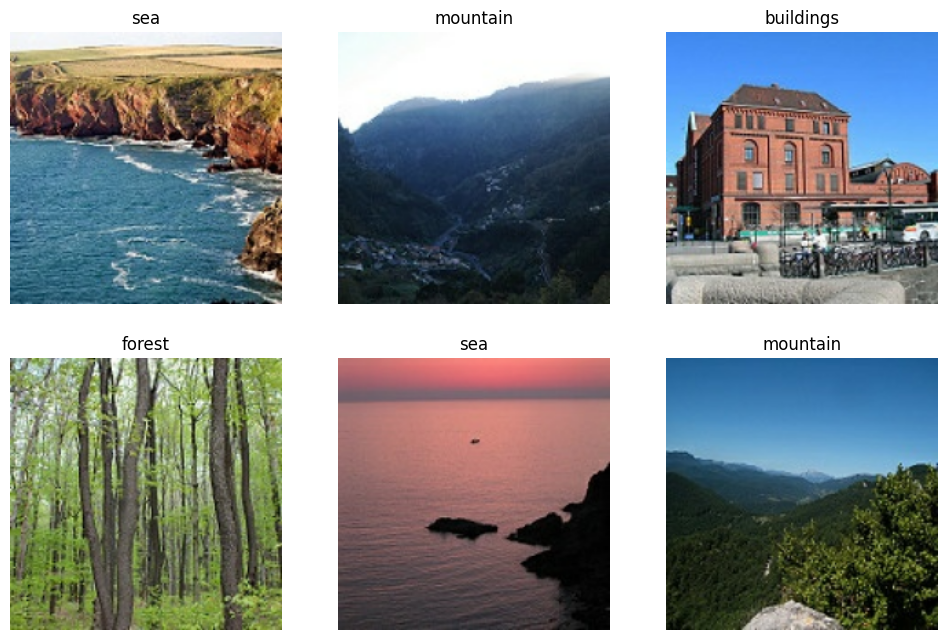

In [149]:

import matplotlib.pyplot as plt

# Label mapping to use when showing the label of an image, will be used at the
# end of the notebook too.
label_mapping = {
    0: 'buildings',
    1: 'forest',
    2: 'glacier',
    3: 'mountain',
    4: 'sea',
    5: 'street'
}

# Fetch a batch of images and labels
for images, labels in train_data.take(1):
    break  # Take only the first batch

# Display some examples
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # Convert to uint8 for
    # visualization
    plt.title(label_mapping[labels[i].numpy()])  # Map numerical label to string
    plt.axis('off')
plt.show()

In [6]:
# Checking the shape of our data
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
# Taking 10% of data. That's only for baseline model, it trains too slow, so
# I had to make this. It's not fair and I know that, but I didn't have enough
# time to wait for it to train.
import tensorflow as tf

def get_dataset_size(dataset):
    # Compute the size of the dataset
    size = 0
    for _ in dataset:
        size += 1
    return size

# Determine the total number of elements in the dataset
train_total_size = get_dataset_size(train_data)
train_subset_size = int(train_total_size * 0.10)  # Calculate 10% of the dataset

test_total_size = get_dataset_size(test_data)
test_subset_size = int(test_total_size * 0.10)


# Create a subset dataset by taking the first `subset_size` elements
train_data_10_percent = train_data.take(train_subset_size)
test_data_10_percent = test_data.take(test_subset_size)

In [10]:
# Separating labels and images to be able to train the baseline model.
import tensorflow as tf
import os
import numpy as np

def extract_features_labels(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:  # Iterate over batches
        for image, label in zip(image_batch, label_batch):  # Iterate within
        # each batch
            image = tf.image.resize(image, (224, 224))
            images.append(image.numpy().flatten())
            labels.append(label.numpy())
    return np.array(images), np.array(labels)

# Extract features and labels
X_train, y_train = extract_features_labels(train_data_10_percent)
X_test, y_test = extract_features_labels(test_data_10_percent)

## Baseline Model

❗This model is not a deep learning model. It's SVM (Support Vector Machine). Starting small with baseline, will make bigger models in the future.

In [11]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data and transform both train and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Create and train the SVM model
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.28      0.35        43
           1       0.79      0.63      0.70        52
           2       0.49      0.54      0.51        54
           3       0.40      0.59      0.48        54
           4       0.27      0.24      0.26        45
           5       0.49      0.50      0.49        40

    accuracy                           0.48       288
   macro avg       0.49      0.46      0.47       288
weighted avg       0.49      0.48      0.47       288



In [14]:
# Storing accuracy to be able to compare with the other models in future.
from sklearn.metrics import accuracy_score
baseline_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {baseline_accuracy}')

Accuracy: 0.4756944444444444


## Preprocess Images

✅ Here, I normalize the images. That effects performance of the model A LOT. Then, I cache and prefetch the data. That makes the model to train faster. And I shuffled the data, which is not really needed because we've done the same when taking the data before, but it feels good.

✅ I've created validation data too, for having a better metric later. Accuracy doesn't give good understanding of the model when it's overfitting, so we need val_accuracy.

In [66]:
import tensorflow as tf

def preprocess_image(image, label):
    # Normalize the image to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

shuffled_test_data = test_data.shuffle(buffer_size=1000, seed=42)

total_size = len(test_data)
val_size = int(0.2 * total_size)
test_size = total_size - val_size

val_data = shuffled_test_data.take(val_size)
test_data = shuffled_test_data.skip(val_size)
# Augment and normalize the train dataset
train_data_10_percent = train_data_10_percent.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
train_data_10_percent = train_data_10_percent.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data_10_percent = test_data_10_percent.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
test_data_10_percent = test_data_10_percent.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Prefetch for performance
test_dataset = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = val_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
for image, label in train_data_10_percent.take(1):
    print(image.shape) # Checking the shape.

(32, 224, 224, 3)


## Dense Model

✅ In this model, I've only used dense layer as learning layers. That's like a baseline model for deep learning models, because it's like the simplest model that can be created as deep learning.

✅ Because model is so simple, it overfits very easily. That's why I've included data augmentation too. I wrote down most of them, but commented out the ones that I don't like to use. If you want, you can uncomment them and they'll be used.

In [166]:
from tensorflow.keras import layers, models
# Create the model
inputs = layers.Input(shape=(224, 224, 3))
x = layers.RandomBrightness(factor=0.2)(inputs)
#x = layers.RandomContrast(factor=0.2)(x)
x = layers.RandomCrop(height=224, width=224)(x)
x = layers.RandomFlip()(x)
#x = layers.RandomHeight(0.1)(x)
#x = layers.RandomWidth(0.1)(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = layers.Flatten()(inputs) # Flatten before dense layer.
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x) # Dropout to prevent overfitting.
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(6, activation='softmax')(x) # Because there's 6 classes.
model_1 = models.Model(inputs=inputs, outputs=outputs)

In [201]:
# Compile the model.
model_1.compile(loss="sparse_categorical_crossentropy", # Because the labels are
                # in integer form, loss is sparse_categorical_crossentropy.
                optimizer=tf.keras.optimizers.Adam(), # Using Adam optimizer
                # because it's the most popular and a safe option.
                metrics=["accuracy"]) # Using accuracy as metric because it's
                # easy to understand.

In [203]:
model_1_history = model_1.fit(train_dataset,
            epochs=5,
                              validation_data=val_dataset,
            callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_1_dense",
                                            verbose=0,
                                            save_best_only=True,
                                  monitor="val_accuracy"), # On every model,
                       # I will use this. That's for comparing best results of
                       # every model, to make it fairer.
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            factor=0.1,
                                                            patience=0) # Because
                       # model stops learning, thought this would save the model,
                       # but it did not.
])

Epoch 1/5
439/439 [==============================] - 42s 95ms/step - loss: 1.7908 - accuracy: 0.1790 - val_loss: 1.7867 - val_accuracy: 0.1823 - lr: 1.0000e-04
Epoch 2/5
439/439 [==============================] - 43s 98ms/step - loss: 1.7908 - accuracy: 0.1790 - val_loss: 1.7867 - val_accuracy: 0.1823 - lr: 1.0000e-04
Epoch 3/5
439/439 [==============================] - 43s 98ms/step - loss: 1.7908 - accuracy: 0.1790 - val_loss: 1.7867 - val_accuracy: 0.1823 - lr: 1.0000e-05
Epoch 4/5
439/439 [==============================] - 43s 98ms/step - loss: 1.7908 - accuracy: 0.1790 - val_loss: 1.7867 - val_accuracy: 0.1823 - lr: 1.0000e-06
Epoch 5/5
439/439 [==============================] - 43s 98ms/step - loss: 1.7908 - accuracy: 0.1790 - val_loss: 1.7867 - val_accuracy: 0.1823 - lr: 1.0000e-07


❌ Metrics stayed the same on all epochs. That's probably because model is too simple to learn anything from the data. Let's make bigger models.

In [204]:
model_1 = tf.keras.models.load_model("model_1_dense") # Taking the best performing
# form of the model.
model_1_score = model_1.evaluate(test_data) # Evaluating model's performance.

76/76 [==============================] - 1s 6ms/step - loss: 1.7899 - accuracy: 0.1807


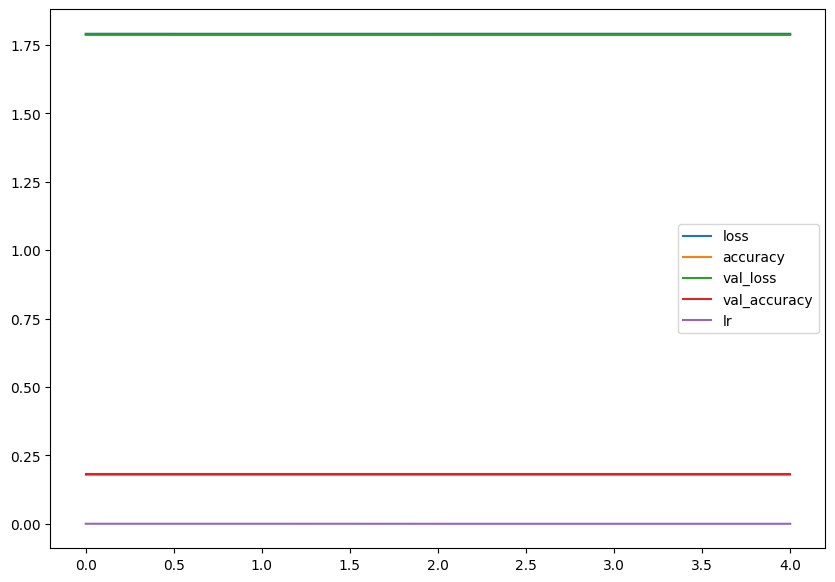

In [205]:
# Visualize what happens when training the model.
import pandas as pd
pd.DataFrame(model_1_history.history).plot(figsize=(10, 7));

## Model 2 - Simple Convolutional Model

✅ Created a small and simple convolutional layer. After that, every model will be convolutional. That also uses data augmentation, because this model is simple too and can overfit.

In [171]:
# Creating the model.
inputs = layers.Input(shape=(224, 224, 3))
x = layers.RandomBrightness(factor=0.2)(inputs)
x = layers.RandomCrop(height=224, width=224)(x)
x = layers.RandomFlip()(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  strides=1,
                  padding="same",
                  activation="relu")(inputs)
x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  strides=1,
                  padding="same",
                  activation="relu")(x)
x = layers.Flatten()(x) # Flatten before dense layer.
outputs = layers.Dense(6, activation="softmax")(x) # Because there's 6 classes.
model_2 = models.Model(inputs=inputs, outputs=outputs)

In [172]:
# Compiling the model (same as model 1)
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [174]:
# Fitting the model (same as model 1)
model_2_history = model_2.fit(train_dataset,
                              validation_data=val_dataset,
            epochs=5,
            callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_2_simple_conv",
                                            verbose=0,
                                            save_best_only=True,
                                  monitor="val_accuracy"),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            factor=0.1,
                                                            patience=1)])

Epoch 1/5
439/439 [==============================] - 260s 591ms/step - loss: 10.1706 - accuracy: 0.4222 - val_loss: 1.2580 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 2/5
439/439 [==============================] - 260s 593ms/step - loss: 0.9915 - accuracy: 0.6382 - val_loss: 1.4191 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 3/5
439/439 [==============================] - 259s 590ms/step - loss: 0.5829 - accuracy: 0.7975 - val_loss: 1.8194 - val_accuracy: 0.5052 - lr: 0.0010
Epoch 4/5
439/439 [==============================] - 259s 591ms/step - loss: 0.2836 - accuracy: 0.9077 - val_loss: 2.2640 - val_accuracy: 0.5278 - lr: 1.0000e-04
Epoch 5/5
439/439 [==============================] - 263s 599ms/step - loss: 0.2359 - accuracy: 0.9214 - val_loss: 2.3553 - val_accuracy: 0.5365 - lr: 1.0000e-04


In [175]:
# Loading the best performing model and evaluating it's performance.
model_2 = tf.keras.models.load_model("model_2_simple_conv")
model_2_score = model_2.evaluate(test_dataset)

76/76 [==============================] - 7s 84ms/step - loss: 2.3302 - accuracy: 0.5318


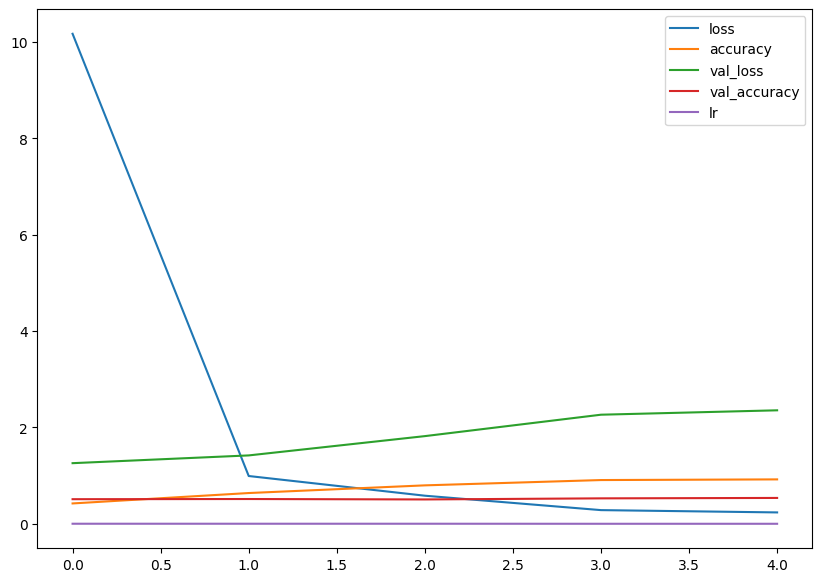

In [176]:
# Visualizing what happens while training.
pd.DataFrame(model_2_history.history).plot(figsize=(10, 7));

## Model 3 - More Advanced Convolutional Model

✅ In this model, there's 2 times more convolutional layers. On top of that, max pooling layers are added. There's still data augmentation to prevent overfitting. Also, dropout layer serves the same purpose.

In [177]:
# Creating the model
inputs = layers.Input(shape=(224, 224, 3))
# Data augmentation
x = layers.RandomBrightness(factor=0.2)(inputs)
x = layers.RandomCrop(height=224, width=224)(x)
x = layers.RandomFlip()(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# First convolutional block
x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  strides=1,
                  padding="same",
                  activation="relu")(inputs)
x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  strides=1,
                  padding="same",
                  activation="relu")(inputs)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.25)(x)

# Second convolutional block
x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  strides=1,
                  padding="same",
                  activation="relu")(inputs)
x = layers.Conv2D(filters=32,
                  kernel_size=3,
                  strides=1,
                  padding="same",
                  activation="relu")(inputs)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.25)(x)

# Flatten and Dense (output) Layers
x = layers.Flatten()(x)
outputs = layers.Dense(6, activation="softmax")(x)
model_3 = models.Model(inputs=inputs, outputs=outputs)

In [178]:
# Compiling the model (same as model 1)
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [180]:
# Fitting the model (same as model 1)
model_3_history = model_3.fit(train_dataset,
                              validation_data=val_dataset,
                              epochs=5,
                              callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_3_max_pool_conv",
                                            verbose=0,
                                            save_best_only=True,
                                  monitor="accuracy"),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            factor=0.1,
                                                            patience=1)])

Epoch 1/5
439/439 [==============================] - 78s 178ms/step - loss: 3.3104 - accuracy: 0.6009 - val_loss: 3.7669 - val_accuracy: 0.5382 - lr: 0.0010
Epoch 2/5
439/439 [==============================] - 77s 176ms/step - loss: 0.8348 - accuracy: 0.7907 - val_loss: 3.2625 - val_accuracy: 0.5747 - lr: 0.0010
Epoch 3/5
439/439 [==============================] - 77s 176ms/step - loss: 0.4109 - accuracy: 0.8759 - val_loss: 3.6560 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 4/5
439/439 [==============================] - 77s 176ms/step - loss: 0.3078 - accuracy: 0.9062 - val_loss: 3.1795 - val_accuracy: 0.5851 - lr: 0.0010
Epoch 5/5
439/439 [==============================] - 78s 179ms/step - loss: 0.3111 - accuracy: 0.9124 - val_loss: 3.9746 - val_accuracy: 0.5226 - lr: 0.0010


In [181]:
# Loading the best performing model and evaluating it's performance.
model_3 = tf.keras.models.load_model("model_3_max_pool_conv")
model_3_score = model_3.evaluate(test_dataset)

76/76 [==============================] - 4s 56ms/step - loss: 3.7882 - accuracy: 0.5623


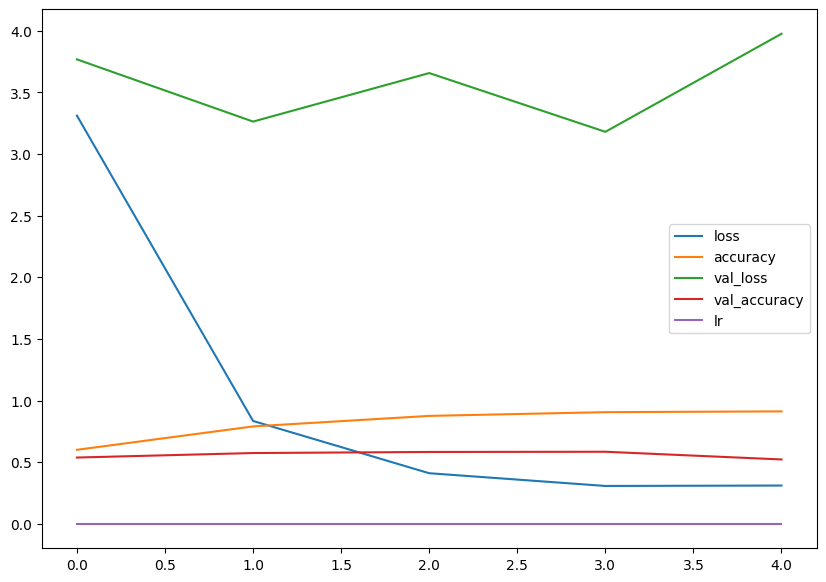

In [182]:
# Visualizing what happens while training.
pd.DataFrame(model_3_history.history).plot(figsize=(10, 7));

## Model 4 - Biggest Convolutional Model

✅ This is the biggest self-created convolutional model on this notebbok. It has 2,5 times the convolutional layers in model 3, it includes a new layer: batch normalization. It also includes max pooling and average pooling layers, and dropout layers. Also, there's data augmentation too.

In [183]:
inputs = tf.keras.Input(shape=(224,224,3))
# Data augmentation
x = layers.RandomBrightness(factor=0.2)(inputs)
x = layers.RandomCrop(height=224, width=224)(x)
x = layers.RandomFlip()(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# First convolutional block
x = layers.Conv2D(filters=64,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Second convolutional block
x = layers.Conv2D(filters=128,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Third convolutional block
x = layers.Conv2D(filters=256,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Fourth convolutional block
x = layers.Conv2D(filters=512,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=512,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=512,
                  kernel_size=3,
                  padding='same',
                  activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Flatten and Dense Layers
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)

x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Output Layer
outputs = layers.Dense(6, activation='softmax')(x)

# Create the model
model_4 = models.Model(inputs=inputs, outputs=outputs)

In [184]:
# Compiling the model (same as model 1)
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [185]:
# Fitting the model (same as model 1)
model_4_history = model_4.fit(train_dataset,
                              validation_data=val_dataset,
                              epochs=1,
                              callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_4_big_conv",
                                            verbose=0,
                                            save_best_only=True,
                                  monitor="val_accuracy")])

439/439 [==============================] - 2266s 5s/step - loss: 1.6924 - accuracy: 0.4351 - val_loss: 2.0108 - val_accuracy: 0.3698


❌ It looks like model doesn't perform as good as the previous models. That's strange because this model is much bigger and there's enough data for a big model to learn. If you look carefully, every model before this one trained for 5 epochs. This model is only trained for 1 epoch, becuase it takes too long to train. It's not fair to train a model much less, but I really don't have enough time.

In [187]:
# Loading the best performing model and evaluating it's performance.
model_4 = tf.keras.models.load_model("model_4_big_conv")
model_4_score = model_4.evaluate(test_dataset)

76/76 [==============================] - 64s 841ms/step - loss: 1.7532 - accuracy: 0.4006


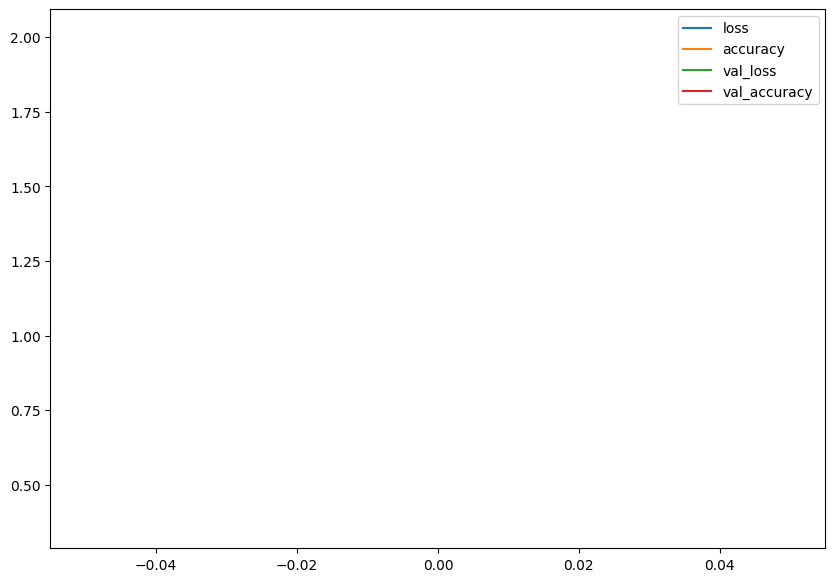

In [188]:
# Visualizing what happens while training.
pd.DataFrame(model_4_history.history).plot(figsize=(10, 7));

❗ Because there's only one epoch, no output is given.

## Model 5 - Fine Tuning Model

✅ In this model, I've used Inception v3 (GoogLeNet) model for fine tuning. I've also created Inception v1 model on TensorFlow before. I was planning to use it on this project, but Inception v1 isn't available on TensorFlow (from library), so I've used Inception v3, which is the closest available.

In [189]:
# Creating the model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3  # Closest available in Keras

# Load the GoogLeNet (InceptionV1 isn't available, but InceptionV3 is similar)
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

inception_model.trainable = True #

inputs = layers.Input(shape=(224, 224, 3))
x = inception_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(6, activation='sigmoid')(x)

model_5 = models.Model(inputs=inputs, outputs=outputs)

In [190]:
# Compiling the model (same as model 1)
model_5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [191]:
# Fitting the model (same as model 1)
model_5_history = model_5.fit(train_dataset,
                              validation_data=val_data,
                              epochs=3,
                              callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_5_fine_tuning",
                                            verbose=0,
                                            save_best_only=True,
                                  monitor="val_accuracy")])

Epoch 1/3
439/439 [==============================] - 579s 1s/step - loss: 0.5744 - accuracy: 0.8070 - val_loss: 0.3875 - val_accuracy: 0.8455
Epoch 2/3
439/439 [==============================] - 556s 1s/step - loss: 0.3758 - accuracy: 0.8713 - val_loss: 0.3576 - val_accuracy: 0.8715
Epoch 3/3
439/439 [==============================] - 547s 1s/step - loss: 0.3318 - accuracy: 0.8900 - val_loss: 0.3277 - val_accuracy: 0.8785


❗ This model has been trained for 3 epochs, which is less than first three models. Again, that's because my time issues.

In [192]:
# Loading the best performing model and evaluating it's performance.
model_5 = tf.keras.models.load_model("model_5_fine_tuning")
model_5_score = model_5.evaluate(test_dataset)

76/76 [==============================] - 28s 343ms/step - loss: 0.3483 - accuracy: 0.8746


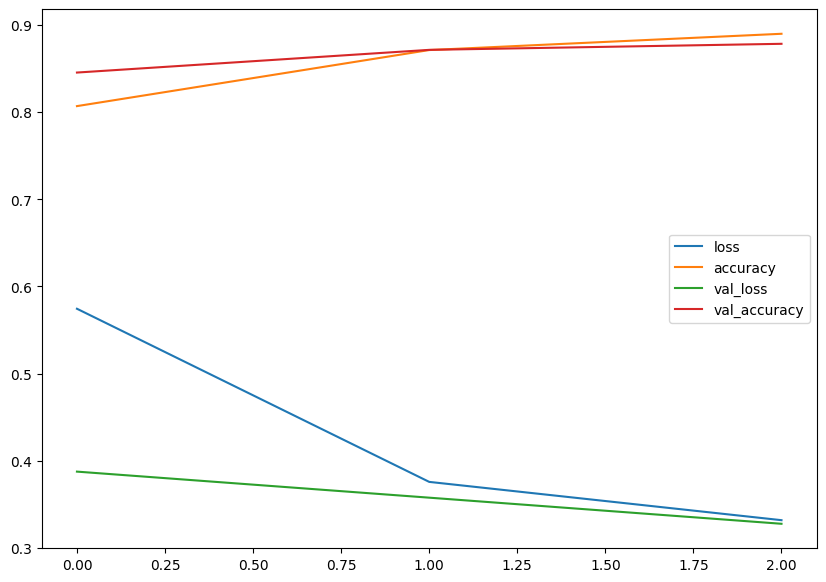

In [193]:
# Visualizing what happens while training.
pd.DataFrame(model_5_history.history).plot(figsize=(10, 7));

## Comparing Performance of the Models Visually

✅ I've stored performance of the models. Here, I will use them to compare. Visualization is a good technique to use in machine learning, so I visualize the performances. I'm only using accuracy, because it's easiest to understand.

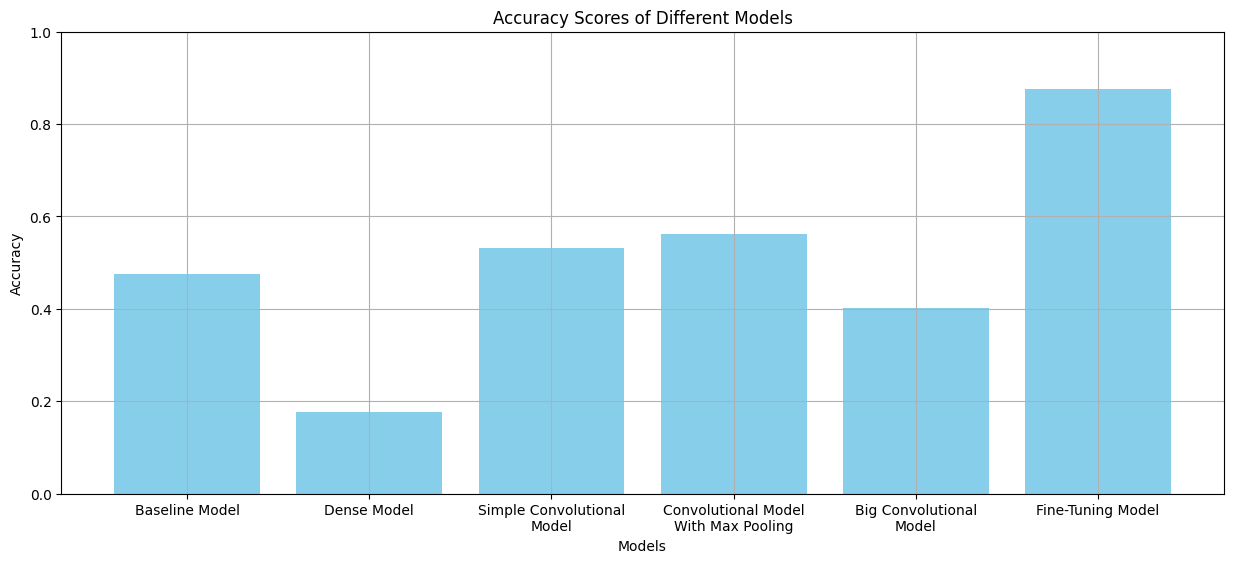

In [198]:
import matplotlib.pyplot as plt
# Taking accuracies of every model (baseline model already has accuracy variable)
accuracy_1 = model_1_score[1]
accuracy_2 = model_2_score[1]
accuracy_3 = model_3_score[1]
accuracy_4 = model_4_score[1]
accuracy_5 = model_5_score[1]

accuracy_scores = [baseline_accuracy, accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5]

model_names = ["Baseline Model", "Dense Model", "Simple Convolutional\nModel",
               "Convolutional Model\nWith Max Pooling","Big Convolutional\nModel",
               "Fine-Tuning Model"] # Naming the models, new lines to prevent
               # long names write on each other

plt.figure(figsize=(15, 6))
plt.bar(model_names, accuracy_scores, color='skyblue')

plt.title('Accuracy Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Because accuracy is between [0,1]
plt.grid(True)
plt.show()

✅ Here, it's obvious that model_5 is the best performing model, so I'll use it to make an example classification.

## An Example Photo

✅ Here I've uploaded an example photo taken by my girlfriend. Resizing and normalizing it to be able to give it to out best performing model. Showing the photo for you to know what we're trying to predict.

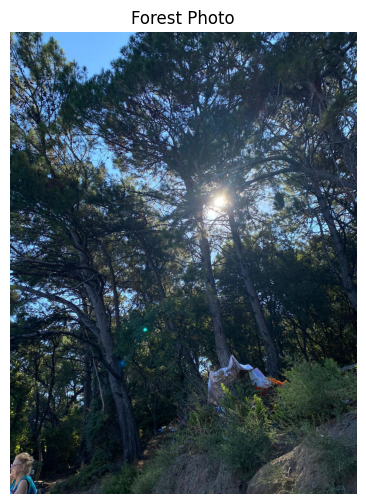

In [199]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Replace 'your_image.jpg' with the actual filename
filename = 'forest_photo.jpg'

# Load the image
img = Image.open(filename)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title('Forest Photo')
plt.axis('off')
plt.show()

# Resize the image to 224x224
img_resized = img.resize((224, 224))

# Convert the image to a numpy array
img_array = np.array(img_resized)

# Normalize the image to the range [0, 1]
img_array_normalized = img_array / 255.0

## Example Classification

✅ Here, I gave this photo to best performing model, which is model_5. As you can see, it predicted the right label for it.

In [200]:
# Reshaping to be able to give it to model.
predictions = model_5.predict(img_array_normalized.reshape(1, 224, 224, 3))
# Taking the biggest possibility, which is prediction of the model.
predicted_label = np.argmax(predictions, axis=1)[0]

# label_mapping is defined at the starting of the notebook, we use it here too.
predicted_class_name = label_mapping[predicted_label]
# Printing the predicted class, which is the right class for this image.
print(f'Predicted class: {predicted_class_name}')

1/1 [==============================] - 0s 76ms/step
Predicted class: forest
